# Chargement des données d’images

Jusqu’à présent, nous avons travaillé avec des ensembles de données assez artificiels, peu représentatifs des projets réels.  
Dans la pratique, vous serez souvent amené à manipuler des **images de grande taille**, comme celles issues d’appareils photo ou de téléphones portables.  
Dans ce notebook, nous verrons comment **charger des images** et les utiliser pour **entraîner des réseaux de neurones**.

Nous utiliserons un [jeu de données de photos de chats et de chiens](https://www.kaggle.com/c/dogs-vs-cats) disponible sur **Kaggle**.  
Voici quelques exemples d’images :



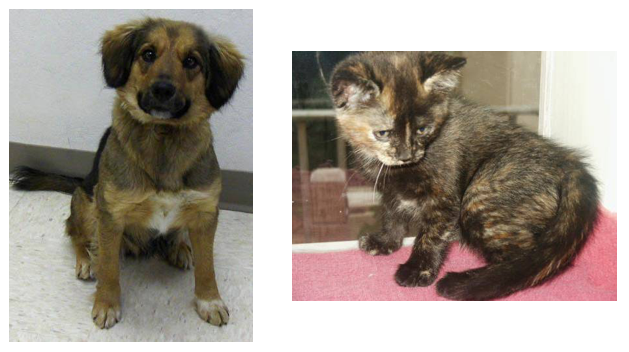

Nous emploierons ce jeu de données pour entraîner un réseau de neurones capable de **distinguer les chats des chiens**.  
Aujourd’hui, cela peut sembler banal, mais il y a encore quelques années, c’était un véritable **défi pour les systèmes de vision par ordinateur**.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import helper


La façon la plus simple de charger des images est d’utiliser `datasets.ImageFolder` de la bibliothèque **torchvision** ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)).  
En général, vous utiliserez `ImageFolder` comme ceci :

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
````

où `'path/to/data'` est le chemin d’accès au répertoire contenant les données, et `transform` est une **séquence d’opérations de prétraitement** définies à l’aide du module [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) de `torchvision`.

`ImageFolder` s’attend à une structure de répertoires comme celle-ci :

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

Chaque classe (ici `cat` et `dog`) possède son **propre dossier** contenant les images correspondantes.
Les images sont alors automatiquement **étiquetées** d’après le nom du dossier.
Ainsi, l’image `123.png` sera chargée avec l’étiquette `cat`.

Vous pouvez télécharger le jeu de données déjà structuré de cette manière [ici](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip).
Il est déjà séparé en **jeu d’entraînement** et **jeu de test**.

---

### 🔄 Transformations

Lors du chargement des données avec `ImageFolder`, il faut définir des **transformations (transforms)**.
Par exemple, les images ont des tailles différentes, mais le modèle nécessite qu’elles aient toutes la même taille pour l’entraînement.
On peut donc :

* les **redimensionner** avec `transforms.Resize()`, ou
* les **rogner** avec `transforms.CenterCrop()` ou `transforms.RandomResizedCrop()`.

Il faut également **convertir les images en tenseurs PyTorch** à l’aide de `transforms.ToTensor()`.

En général, ces étapes sont combinées en un pipeline à l’aide de `transforms.Compose()`, qui exécute une liste de transformations dans l’ordre.
Par exemple, pour redimensionner, recadrer, puis convertir en tenseur :

```python
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
```

Il existe de nombreuses autres transformations possibles — consultez la [documentation](http://pytorch.org/docs/master/torchvision/transforms.html) pour plus de détails.

---

### 📦 Data Loaders

Une fois le `ImageFolder` chargé, il faut le passer à un [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader).
Le **DataLoader** prend un dataset (par exemple celui renvoyé par `ImageFolder`) et retourne des **lots (batches)** d’images et leurs **étiquettes** correspondantes.
Vous pouvez régler plusieurs paramètres, comme :

* la **taille des lots (`batch_size`)**,
* et le **mélange des données (`shuffle`)** à chaque époque.

Exemple :

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

L’objet `dataloader` est un **générateur**.
Pour extraire des données, on peut soit boucler dessus, soit le convertir en itérateur et appeler `next()` :

```python
# Boucle pour récupérer un batch à chaque itération
for images, labels in dataloader:
    pass

# Obtenir un seul batch
images, labels = next(iter(dataloader))
```

---

> **Exercice :**
> Chargez les images depuis le dossier `Cat_Dog_data/train`,
> définissez quelques transformations,
> puis construisez le **DataLoader**.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# setting working Directory
import os
os.chdir('cat_dog_image_classification')

In [4]:
%ls

Cat_Dog_data/
Part 7 - Loading Image Data (exo)_v2.ipynb
__MACOSX/
helper.py


In [8]:
cd ..

/Users/jiby/Documents/Wrangler/Mbodj DL


In [9]:
data_dir = 'cat_dog_image_classification/Cat_Dog_data/train'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

<Axes: >

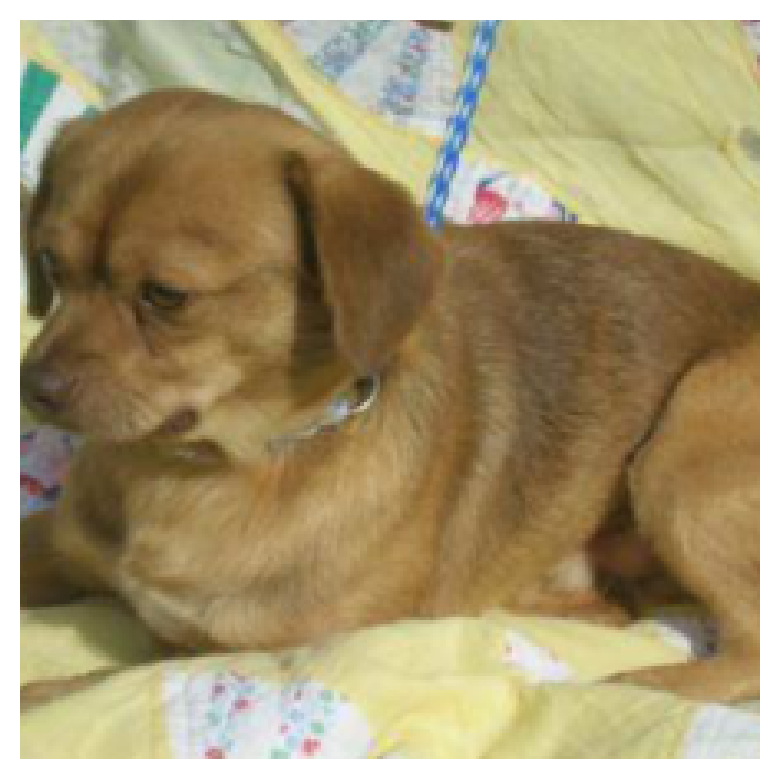

In [11]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
imshow(images[0], normalize=False)

Si vous avez correctement chargé les données, vous devriez obtenir un affichage similaire à celui-ci (votre image sera différente) :




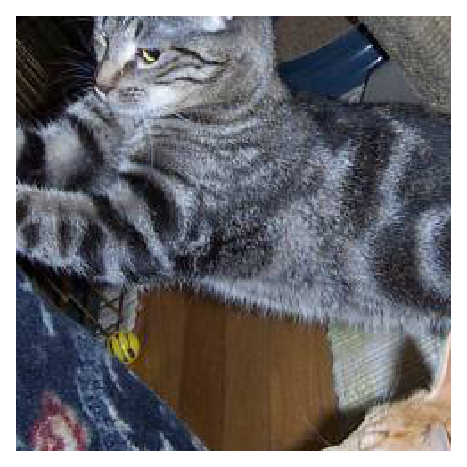


## Augmentation de Données

Une stratégie courante pour entraîner des réseaux de neurones consiste à introduire une **certaine forme d’aléatoire dans les données d’entrée**.  
Par exemple, on peut faire tourner, refléter, redimensionner et/ou rogner aléatoirement les images pendant l’entraînement.  
Cela aide le réseau à **mieux généraliser**, car il voit les mêmes images sous différentes formes : positions, tailles, orientations, etc.

Pour appliquer une rotation, un recadrage et un redimensionnement aléatoires, puis retourner les images horizontalement, on peut définir les transformations ainsi :

```python
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])
````

Il est également recommandé de **normaliser les images** à l’aide de `transforms.Normalize`.
Cette transformation prend en entrée :

* une liste de **moyennes** (`mean`)
* et une liste d’**écarts-types** (`std`)

Chaque canal de couleur est alors normalisé selon la formule :

```
input[channel] = (input[channel] - mean[channel]) / std[channel]
```

Soustraire la moyenne recentre les données autour de zéro,
et diviser par l’écart-type comprime les valeurs entre **-1 et 1**.
Cette normalisation aide à maintenir les **poids du réseau proches de zéro**,
rendant ainsi la **rétropropagation plus stable**.
Sans normalisation, le réseau risque souvent d’échouer à apprendre correctement.

Vous pouvez consulter la **liste complète des transformations disponibles** [ici](http://pytorch.org/docs/0.3.0/torchvision/transforms.html).

Lors des phases de **validation** ou de **test**, on utilise généralement des images **non altérées** (hormis la normalisation).
Ainsi, pour les données de validation ou de test, on se contente en général de **redimensionner** et **recadrer** les images.

---

> **Exercice :**
> Définissez ci-dessous les **transformations** pour les données d’entraînement et de test.
> Ne mettez pas encore la normalisation.

```



In [12]:
data_dir = 'cat_dog_image_classification/Cat_Dog_data'

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [13]:
# change this to the trainloader or testloader
data_iter = iter(trainloader)

In [14]:
images, labels = next(data_iter)
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3060222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0299783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


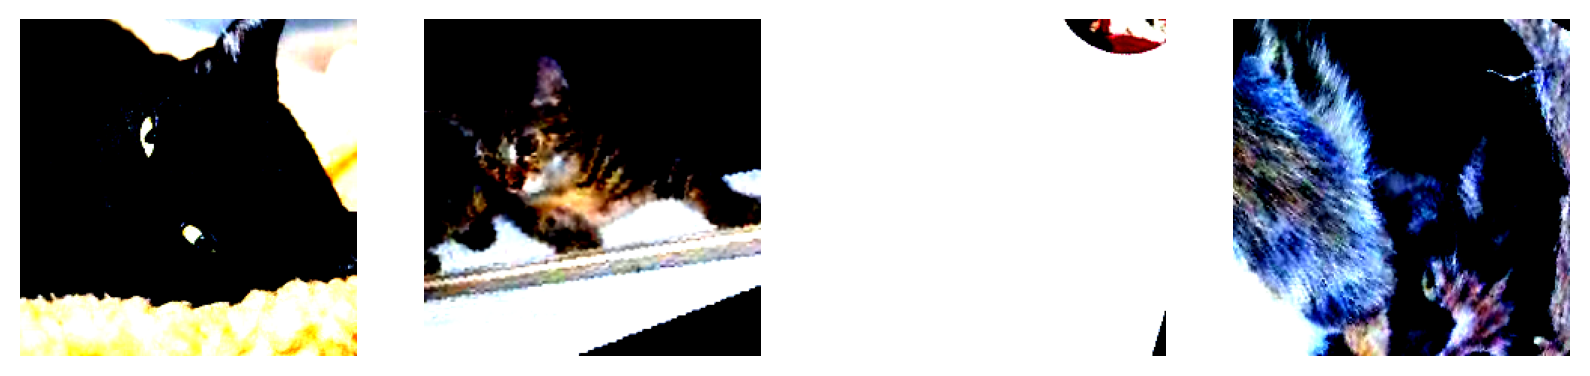

In [15]:


images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)

Vos images transformées devraient ressembler à quelque chose comme ceci.




<center>Training examples:</center>


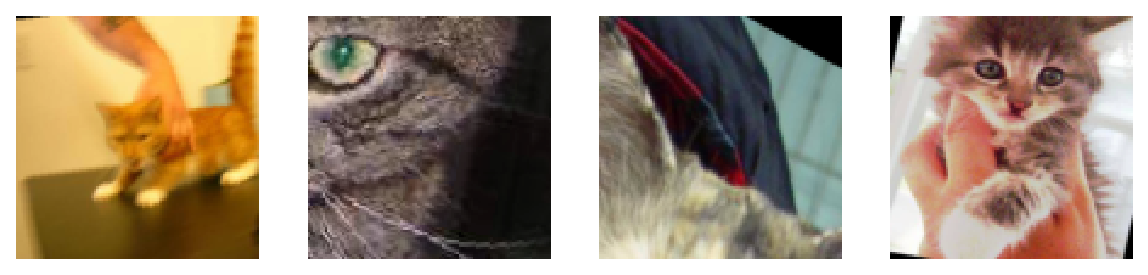

<center>Testing examples:</center>

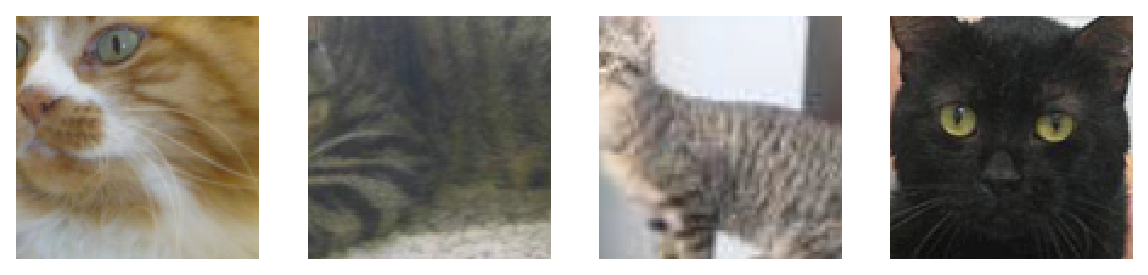


À ce stade, vous devriez être en mesure de charger les données pour l’entraînement et le test.  
Vous pouvez maintenant essayer de construire un réseau capable de **classer les chats et les chiens**.



In [16]:
# Build a network with CNN to classify cats vs dogs from this dataset
# Creating a model from scratch

import torch.nn as nn
import torch.nn.functional as F

class CatDogClassifier(nn.Module):
    def __init__(self):
        super(CatDogClassifier, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  # 2 classes: cat and dog
        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        # Flatten the tensor
        x = x.view(-1, 256 * 14 * 14)
        
        # Fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Create the model
model = CatDogClassifier()
print(model)

CatDogClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [17]:
# Training setup
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Training on: {device}")

# Print dataset info
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Classes: {train_data.classes}")

Training on: cpu
Training samples: 22500
Test samples: 2500
Classes: ['cat', 'dog']


In [18]:
# Training function
def train_model(model, trainloader, testloader, criterion, optimizer, epochs=5):
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        running_loss = 0
        model.train()
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Validation
        test_loss = 0
        accuracy = 0
        model.eval()
        
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                test_loss += criterion(outputs, labels).item()
                
                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/len(trainloader):.3f}.. "
              f"Test loss: {test_loss/len(testloader):.3f}.. "
              f"Test accuracy: {accuracy/len(testloader):.3f}")
    
    return train_losses, test_losses

In [ ]:
# Start training
epochs = 5
train_losses, test_losses = train_model(model, trainloader, testloader, criterion, optimizer, epochs)

# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

Epoch 1/5.. Train loss: 8.521.. Test loss: 3135.809.. Test accuracy: 0.506


# TP – CNN “from scratch” vs Transfert Learning (Cats vs Dogs)

## Objectif

Comparer **un modèle CNN entraîné from scratch** et **un modèle en transfert d’apprentissage** sur le même jeu de données (cats vs dogs). Montrer l’impact du transfert learning sur la convergence, la performance et la robustesse.

## Ce qui est **obligatoire**

1. **Deux expériences distinctes**

   * Expérience A : CNN **from scratch** (architecture simple minimum 3 bloc avec conv).
   * Expérience B : **Transfert learning** (ex. ResNet, MobileNet, EfficientNet…), couches finales adaptées.
2. **Bonnes pratiques de régularisation**

   * Utiliser **Dropout** ET **Batch Normalization** (justifier où et pourquoi).
3. **Suivi des métriques**

   * **Training loss**, **Accuracy**, **Précision**, **Recall** à chaque époque (et idéalement sur train/val si vous faites une validation).
   * Tracer des **courbes** et **comparer** les deux approches.
4. **Optimisation**

   * Tester au moins **2 optimiseurs** (ex. SGD et Adam).
   * Chercher un **bon learning rate** (essais ou scheduler).
5. **GPU**

   * Entraîner **sur GPU** si disponible (vérification et mention dans README).
6. **Persistance du modèle**

   * **Sauvegarder** le meilleur modèle (.pt/.pth) localement (ne **pas** pousser dans GitHub).
   * **Recharger** le modèle pour faire le **test final** et rapporter les métriques.
7. **Reproductibilité**

   * Fixer un **seed**

## Ce qui est **souhaité (bonus)**

* **Split train/validation** (clair et justifié).
* **Data augmentation** raisonnable.
* **Scheduler** (ex. StepLR, CosineAnnealingLR).
* **Matrice de confusion** et quelques **erreurs typiques** commentées.
* Journalisation (TensorBoard/W&B) — sans pousser les fichiers lourds.

## Données

* Utilisez le même corpus **Cats vs Dogs** que vu en cours (ou équivalent).
* Ne **poussez pas** les données sur GitHub. Indiquez seulement **comment** les télécharger/placer.

## Structure du dépôt GitHub (exemple)

```
cnn-catsdogs-<NomPrenom>/
├─ notebook.ipynb
├─ .gitignore
├─ requirements.txt (ou environment.yml)
├─ README.md
└─ LICENSE (optionnel)
```

### `.gitignore` (minimum)

```
data/
*.pt
*.pth
runs/
checkpoints/
```

## Contenu attendu du **README.md**

* **Titre & objectif** du projet.
* **Environnement** ( `pip install -r requirements.txt` ou `conda env create -f environment.yml`).
* **Organisation des données** (où télécharger, où placer les dossiers).
* **Commandes pour entraîner** :

  * From scratch : arguments clés (batch size, lr, epochs, optimiser, dropout, BN, scheduler…).
  * Transfert learning : même chose + quelle base (gel des couches ou fine-tuning).
* **Commandes pour évaluer / recharger le modèle** (chemin du checkpoint local).
* **Résultats** : tableaux + courbes (loss/accuracy/précision/recall) pour les deux expériences, **comparaison et analyse** (2–3 paragraphes).
* **Limites & pistes d’amélioration** (brèves).

## Évaluation (grille indicative)

* Rigueur expérimentale & métriques (30 %)
* Qualité des modèles & optimisation (25 %)
* Clarté du code & structure du dépôt (20 %)
* README (reproductibilité, analyse, figures) (20 %)
* Bonus (val split, augmentation, scheduler, confusion matrix) (5 %)

## Remise

* **Poussez votre code sur GitHub** (sans données ni modèles).
* Envoyez **le lien du dépôt** à **[diallomous@gmail.com](mailto:diallomous@gmail.com)**
* **Date limite : mercredi  22 octobre 2025 à 18:00 (Africa/Dakar).**

> Rappel : ne chargez pas les fichiers lourds (datasets, `.pt/.pth`). Assurez-vous que votre dépôt permet de **reproduire** les expériences via les instructions du README.


In [ ]:
# Model evaluation and prediction function
def predict_image(model, image_path, transform, class_names):
    """Predict the class of a single image"""
    from PIL import Image
    
    # Load and preprocess the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_class].item()
    
    return class_names[predicted_class], confidence

# Test the model on a few images
import os
import random

# Get some test images
test_cat_dir = "cat_dog_image_classification/Cat_Dog_data/test/cat"
test_dog_dir = "cat_dog_image_classification/Cat_Dog_data/test/dog"

if os.path.exists(test_cat_dir) and os.path.exists(test_dog_dir):
    cat_images = [os.path.join(test_cat_dir, f) for f in os.listdir(test_cat_dir)[:5]]
    dog_images = [os.path.join(test_dog_dir, f) for f in os.listdir(test_dog_dir)[:5]]
    
    print("Sample predictions:")
    for img_path in cat_images + dog_images:
        pred_class, confidence = predict_image(model, img_path, test_transforms, train_data.classes)
        actual_class = "cat" if "cat" in img_path else "dog"
        print(f"Image: {os.path.basename(img_path)} | Predicted: {pred_class} ({confidence:.3f}) | Actual: {actual_class}")
else:
    print("Test directories not found. Please check the data path.")

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "cat_dog_classifier.pth")
print("Model saved as cat_dog_classifier.pth")

# To load the model later:
# model = CatDogClassifier()
# model.load_state_dict(torch.load("cat_dog_classifier.pth"))
# model.eval()